KNN model


Import dependencies

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Import data

In [337]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

Establish inputs and output columns.

In [338]:
x = df.drop('energy', axis=1)
y = df['energy']




Import sklearn dependencies for standardization and train/test split.

In [339]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [340]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



# Now do Holdout Method

Split the data into training and testing sets.

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Import model from sci-kit learn and fit the data and then predict the output.

In [342]:
from sklearn.neighbors import KNeighborsRegressor

In [343]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [344]:
y_pred = knn.predict(X_test)

Creating a Dummy regressor to see if the model is better than random chance.

In [345]:
from sklearn.dummy import DummyRegressor

In [346]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

Import dependencies for evaluation metrics. And calculate mean squared error and r2 score.

In [347]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [348]:
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)




The model's mse:  12472359318684.037
The dummy's mse:  64233127139167.26
Relative error:  0.194173316389555


In [349]:
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)


The model's r2:  0.8052146826812404
The dummy's r2:  -0.0031518281738402987


In [350]:
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

The model's mae:  2454358.6894977167
The dummy's mae:  6804090.003878151
Relative error:  0.36071813983924333


In [351]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse_dummy = mean_squared_error(y_test, y_pred_dummy, squared=False)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

The model's mae:  2454358.6894977167
The dummy's mae:  6804090.003878151
Relative error:  0.36071813983924333


# That was the Holdout Method, now do K-Fold Cross Validation

Pt.2 Hyper parameter tuning with cross validation

In [352]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score


scores = cross_val_score(knn, X, y, cv=5)
print(scores)
print(scores.mean())


# Define the search space

param_grid = {
    'n_neighbors': list(range(1, 50)),
}

# Define the cross validation scheme.

cv = KFold(n_splits=5, shuffle=True, random_state=56)

better_knn = GridSearchCV(knn, param_grid, cv=cv, n_jobs=-1)

# print out the best score and parameters



scores = cross_val_score(better_knn, X, y, cv=cv)
print(scores)
print(scores.mean())

better_knn.fit(X, y) 
print(better_knn.best_params_)
print(better_knn.best_score_)


[0.74456232 0.78240433 0.81307038 0.79727357 0.73347094]
0.7741563084938978


[0.8023157  0.83772604 0.84144952 0.81327229 0.79993167]
0.8189390416519021
{'n_neighbors': 19}
0.8211663299283527


In [353]:
import matplotlib.pyplot as plt

prediction_scores = {}
n_neighbors = np.arange(2, 60, 1)

for neighbors in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    prediction_scores[neighbors] = mean_absolute_error(y_test, y_pred)/mae_dummy
    

Plot the scores

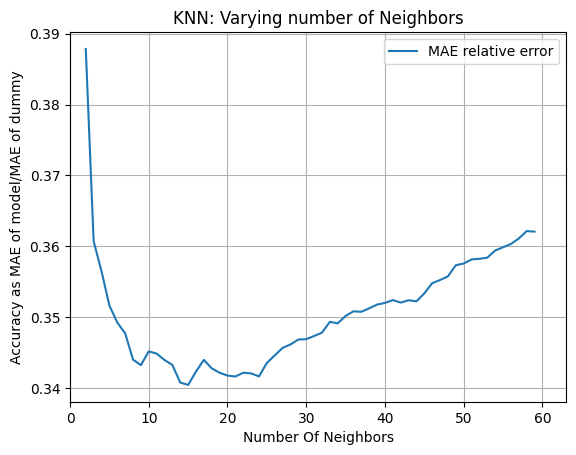

In [354]:
plt.plot(n_neighbors, prediction_scores.values(), label="MAE relative error")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy as MAE of model/MAE of dummy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 63)
plt.grid()
plt.show()
